# scRNAseq downstream analysis
The whole analysis is divided in multiple steps:
1. Scripts: file zippers, marker table modifier and data path retriever
2. chunk by chunk to understand whole proccess and optimize time of plotting

Based on Jupyter Notebook created by Lauren Sanders.

### Updates:

1. Wrote script to zip all downloaded samples and give possibility to open as adata
2. Wrote script to modify marker table and adapted to be read by ScoreCT
3. Prepared the function that will process and plot all data that are needed to visualization - the function is also written to be easily incorporated with Django (system that is used on Viz Portal)
4. Finished cell type annotation with scoreCT - it works properly, when good markers are provided.
5. Found tools for DE analysis: I will test them in next update; Python: diffxpy, PyDESeq2, R: DESeq2 - I will compare them together
6. added optional function to run mt filtering step - works on booleans
7. it is possible to interactively compare multiple samples/tissues/genes at the same time - I have to face with scalability challenges and probably I need to move all plots to separate function / script

### Updates:
1. added sample_name marker to identify samples in adata
2. Removed basic filtering with fixed thresholds: 300genes and min. 3 cells. Instead of added dynamic threshold for 5th percentile of cells and 1st percentile of genes

#### Updates:
1. I have to check the code again because UMAP results are different that I expected - despite the same code, they vary from reference notebook I received.
2. Plot titles in violin and highly variable genes does not work
3. I have to prepare one more function for summary table - the last summary table is not good as I wanted
4. I have to readapt function sc_process() - it must contain all optional processes and have all necessary functions to run from users interface.

Next step:
1. finish UMAP
2. DE analysis of sample
3. final table of results
4. Incorporation to Django code
   

### Script: Zip all files for scanpy (optional):

In [ ]:
# Set the working folder:
root_folder = './test/'

In [13]:
# Define the file extensions we are looking for
extensions = ('.tsv', '.mtx')
#load libraries:
import os
import gzip
import shutil
# Function to find and zip files
def zipper(root_folder):
 
    # Walk through the directory, including subdirectories
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            # Check if the file is in a 'filtered' subdirectory:
            if 'filtered' in root:
                # Check for the desired file extension:
                if file.endswith(extensions):
                    file_path = os.path.join(root, file)
                    output_path = file_path + '.gz'  # Create the .gz filename
                    
                    # Zip the file:
                    with open(file_path, 'rb') as f_in:
                        with gzip.open(output_path, 'wb') as f_out:
                            shutil.copyfileobj(f_in, f_out)
                    
                    print(f"Successfully zipped: {file_path} to {output_path}")
                else:
                    print(f"Skipping non-target file: {file}")
#execute the function:
zipper(root_folder)

Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene\filtered\barcodes.tsv to ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene\filtered\barcodes.tsv.gz
Skipping non-target file: barcodes.tsv.gz
Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene\filtered\features.tsv to ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene\filtered\features.tsv.gz
Skipping non-target file: features.tsv.gz
Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene\filtered\matrix.mtx to ./test/RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene\filtered\matrix.mtx.gz
Skipping non-target file: matrix.mtx.gz
Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_YNG_FY11_Gene\filtered\barcodes.tsv to ./test/RRRM2_Femur_BM_FLT_LAR_YNG_FY11_Gene\filtered\barcodes.tsv.gz
Skipping non-target file: barcodes.tsv.gz
Successfully zipped: ./test/RRRM2_Femur_BM_FLT_LAR_YNG_FY11_Gene\filtered\features.tsv to ./test/RRRM2_Femur_BM_FLT_LAR_YNG_FY11_Gene\filtered\features.tsv.gz
Skipping non-target file: features.tsv.gz
Success

### Script: prepare marker table for scoreCT (optional):

In [ ]:
#Load libraries:
import pandas as pd

#Load inputs:
df_input='GL-DPPD-7111_Mmus_BoneMarrow_CellType_GeneMarkers.csv'
df_output='GL-DPPD-7111_Mmus_BoneMarrow_CellType_GeneMarkers_filtered.csv'
column_name='cellName'
column_gene='geneSymbol'

#load_data:
df = pd.read_csv(df_input)
df = pd.DataFrame(df)
#Select only cellName and geneSymbol:
df_selected = df[[column_name, column_gene]]
#Create new column for each representing gene:
df_split = df_selected[column_gene].str.split(',', expand=True)
# Concatenate the "one" column with the newly split columns
df_result = pd.concat([df[[column_name]], df[column_gene].str.split(',', expand=True)], axis=1).to_numpy()
#save results:
pd.DataFrame(df_result).to_csv(df_output, header=False, index=False)

Select Inputs:

### Script: retrieve all file paths (2nd step optional):

In [324]:
base_path = './test'

In [582]:
'''This script uses a loop to find all subdirectories
of working directory that contain scRNAseq datasets.

'''

out = []
# find all subdirectories:
for root, dirs, files in os.walk(base_path):
    # it was a problem with catching invisible folders, fixed it:
    dirs[:] = [d for d in dirs if not d.startswith('.')]
    # Check if the current directory matches the filtered path
    if 'filtered' in root.split(os.sep):
         out.append(root)
out

['./test\\RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene\\filtered',
 './test\\RRRM2_Femur_BM_FLT_LAR_YNG_FY11_Gene\\filtered']

### Downstream analysis - chunk by chunk:

#### Load libraries:

In [315]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

import os
import sys
import scanpy as sc
import scorect as ct
# Ignore warnings in this tutorial
import warnings
warnings.filterwarnings('ignore')

scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.8 pynndescent==0.5.13


#### Import data:

In [583]:
#scanPy marker path
marker_file = 'GL-DPPD-7111_Mmus_BoneMarrow_CellType_GeneMarkers_filtered.csv'
#single_sample_path:
input_path = './test/RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene/filtered/'

In [584]:
adata = sc.read_10x_mtx(input_path,var_names='gene_symbols',cache=True)

... reading from cache file cache\test-RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene-filtered-matrix.h5ad


In [585]:
adata

AnnData object with n_obs × n_vars = 3278 × 56748
    var: 'gene_ids', 'feature_types'

In [586]:
#Catch sample name:
sample_name = os.path.basename(os.path.dirname(os.path.dirname(input_path)))
sample_name

'RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene'

#### Basic filtering:
- changed from fixed numbers of filtered n= 300 genes and n = 3 cells to dynamically filter percentiles based on species - for now implemented only "mouse" specie as a standard
- for "mouse": 5th percentile of genes, 1st percentile of cells

In [587]:
def BasicFiltering(adata, organism):
    if organism in ("mouse","mus", "Mus", "Mouse", "Mus musculus", "Mus Musculus"):
        
        stat = sc.pp.calculate_qc_metrics(adata)
        cdf = stat[0]
        gdf = stat[1]

        genes = list(set(cdf['n_genes_by_counts'])) # already sorted, why?
        cells = list(set(gdf['n_cells_by_counts']))
    
        print('Filter out cells expressing fewer than: ' + str(np.percentile(genes, 5)) + ' genes (5th percentile)')
        print('Filter out genes detected in fewer than: ' + str(np.percentile(cells, 1)) + ' cells (1st percentile)')

In [588]:
BasicFiltering(adata, "mus")

Filter out cells expressing fewer than: 267.6 genes (5th percentile)
Filter out genes detected in fewer than: 19.75 cells (1st percentile)


#### Plot 1 and 2: Distribution plot of genes vs cells and cells vs genes:

In [589]:
def plotCellsAndGenes(adata, organism):
    if organism in ("mouse","mus", "Mus", "Mouse", "Mus musculus", "Mus Musculus"):
        
        #setup thresholds:
        minGenes=np.percentile(genes, 5)
        minCells=np.percentile(cells, 1)
        #distribution of filtered Cells and Genes:
        stats = sc.pp.calculate_qc_metrics(adata)
        cell_qc_dataframe = stats[0]
        gene_qc_dataframe = stats[1]
    
        fig, axes = plt.subplots(ncols=2, figsize=(12,4))

        axes[0].hist(cell_qc_dataframe['n_genes_by_counts'], bins="sqrt")
        axes[0].set(xlabel='N genes', ylabel='N cells')
        axes[0].axvline(minGenes, color='red')
        axes[0].set_title("Number of genes by counts")

        axes[1].hist([int(x) for x in gene_qc_dataframe['n_cells_by_counts'] if not x==0], bins="sqrt")
        axes[1].set(xlabel='N cells expressing > 0', ylabel='N genes')#, yscale='log')
        axes[1].axvline(minCells, color='red')
        axes[1].set_title("Number of cells by counts")

        
        fig.suptitle(f"{sample_name}", fontsize=16)
        fig.subplots_adjust(top=0.8)
        
        plt.show()

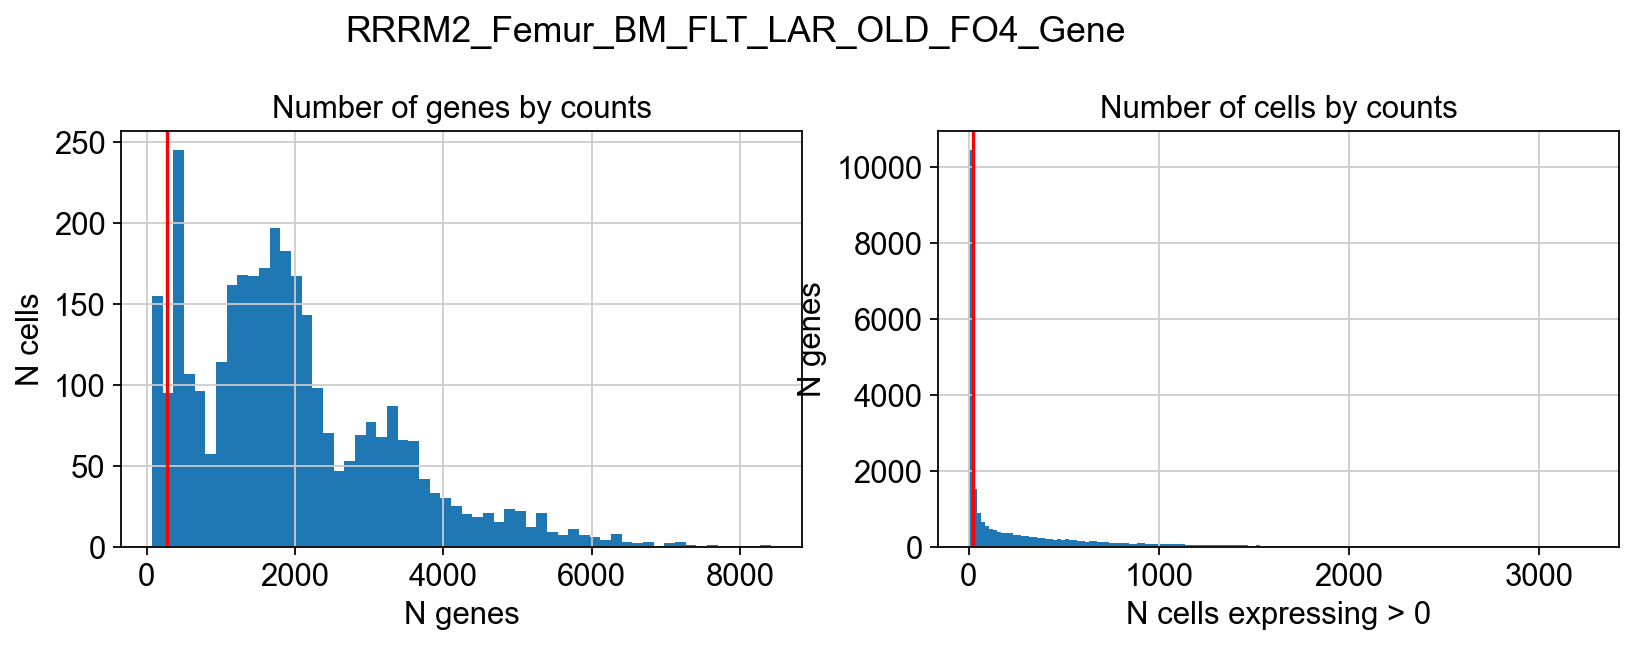

In [590]:
plotCellsAndGenes(adata, "mus")

#### Annotate mitochondrial genes (optional):
- This step should remain optional

Identify the prefix of mt genes (classic scRNAseq analysis approach):

In [591]:
# Check for common mitochondrial gene prefixes in the first 50 gene names
def mtAnalysis(adata):
    mitochondrial_prefixes = ["MT-", "mt-", "M-", "m-", "mito-", "MITO-"]

# Find which prefix is used in your data
    for prefix in mitochondrial_prefixes:
        mt_genes = [gene for gene in adata.var_names if gene.startswith(prefix)]
        if mt_genes:
            print(f'Prefix "{prefix}" found with {len(mt_genes)} mitochondrial genes:')
            print(mt_genes[:10])  # Print the first 10 mitochondrial genes found
            break
    else:
        print("No common mitochondrial gene prefix found in the first 50 gene names.")

    # annotate the group of mitochondrial genes as "mt"
    adata.var["mt"] = adata.var_names.str.startswith("mt-")

In [592]:
mtAnalysis(adata)

Prefix "mt-" found with 37 mitochondrial genes:
['mt-Tf', 'mt-Rnr1', 'mt-Tv', 'mt-Rnr2', 'mt-Tl1', 'mt-Nd1', 'mt-Ti', 'mt-Tq', 'mt-Tm', 'mt-Nd2']


#### Calculate metrics:

In [593]:
mt_analysis = True #only for testing purposes!!!

In [594]:
if mt_analysis:
    
    mtAnalysis(adata)
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
    print(f"Annotated mitochondrial genes and calculated QC metrics.")
else:
    sc.pp.calculate_qc_metrics(
        adata, percent_top=None, log1p=False, inplace=True)
    print(f"Calculated QC metrics.")

Prefix "mt-" found with 37 mitochondrial genes:
['mt-Tf', 'mt-Rnr1', 'mt-Tv', 'mt-Rnr2', 'mt-Tl1', 'mt-Nd1', 'mt-Ti', 'mt-Tq', 'mt-Tm', 'mt-Nd2']
Annotated mitochondrial genes and calculated QC metrics.


#### Plot: Violin
- title does not work
all inputs are boolean:

In [595]:
def plotViolin(adata, genes, total, pct_mt):
    if genes:
        sc.pl.violin(adata,
                     "n_genes_by_counts",
                     jitter=0.4,     
                     )
        
    if total:
        sc.pl.violin(adata,
                     "total_counts",
                     jitter=0.4,
                    )
    if pct_mt:
        #safety - to avoid code crashing if somebody will not choose mt_analysis:
        if mt_analysis:
            sc.pl.violin(adata,
                         "pct_counts_mt",
                         jitter=0.4,
                        )
        else:
            print(f"ERROR: There is no pct_counts_mt data to generate plot.")

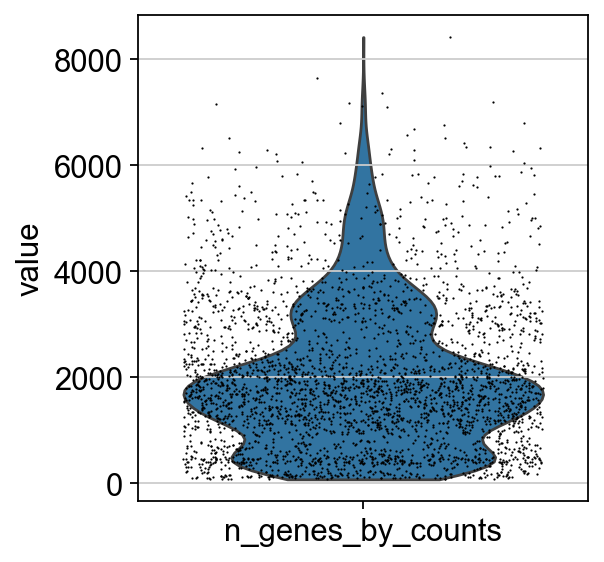

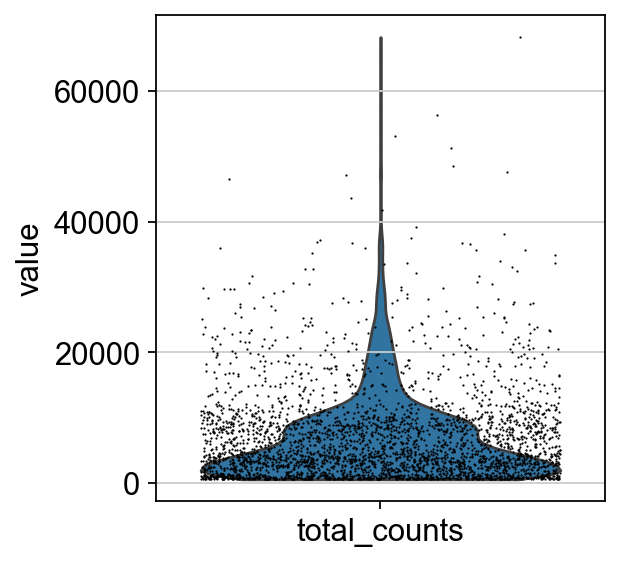

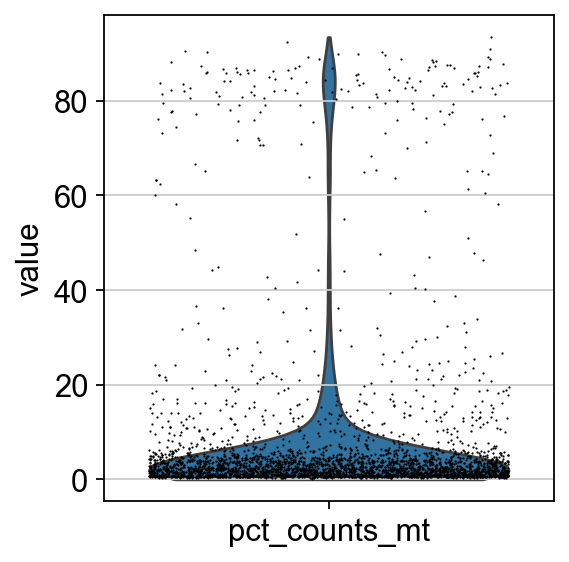

In [596]:
plotViolin(adata,True, True, True)

#### Plot: Scatter
All inputs except adata are boolean:

In [597]:
def plotScatter(adata, mt_counts, gene_counts):
    if mt_counts:
        sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", title="Percent of mitochondrial counts")
    if gene_counts:
        sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", title="Number of genes vs total counts")

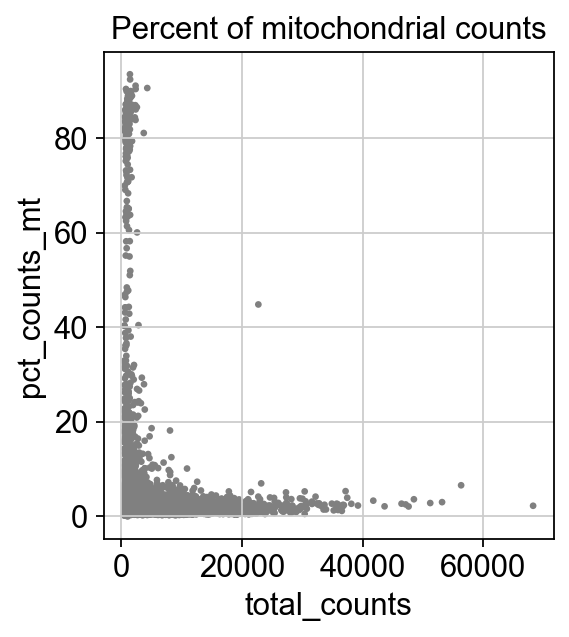

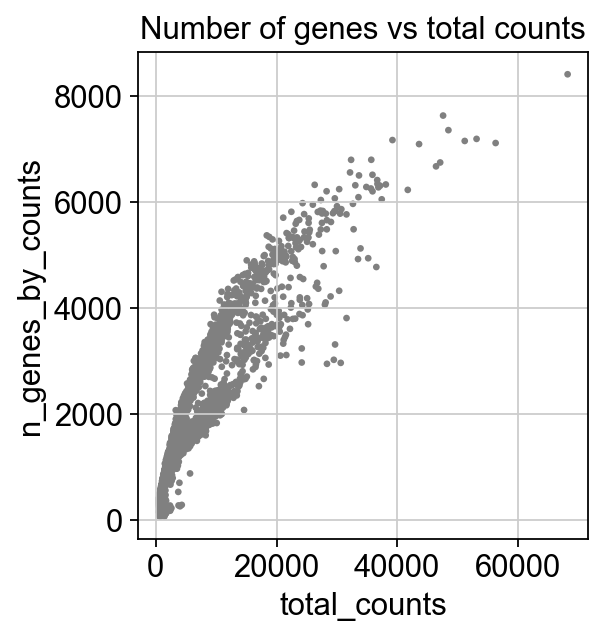

In [598]:
plotScatter(adata, True, True)

#### Filter cells based on gene counts:

In [599]:
if mt_analysis:  
    adata = adata[adata.obs.n_genes_by_counts < 2500, :]
    adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
    print(f"Filtered cells based on gene counts.")
else:
    adata = adata[adata.obs.n_genes_by_counts < 2500, :]
    print(f"Filtered cells based on gene counts.")

Filtered cells based on gene counts.


In [603]:
adata

AnnData object with n_obs × n_vars = 1698 × 56748
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

#### Read depth normalization and identification of high variable genes:

In [604]:
def Normalization(adata):
    #correct for library size:
    sc.pp.normalize_total(adata, target_sum=1e4)

    #Perform log transformation:
    sc.pp.log1p(adata)

    #Identify high variable genes:
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    
    #freeze state:
    adata.raw = adata

    #filter highly variable genes:
    adata = adata[:, adata.var.highly_variable]

    #Regress out the effect of total counts per cell and mitochondrial genes expressed:
    if mt_analysis:
        sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
        sc.pp.scale(adata, max_value=10)
    else:
        sc.pp.regress_out(adata, "total_counts")
        sc.pp.scale(adata, max_value=10)

In [605]:
Normalization(adata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:46)


#### Plot: post-normalization

In [607]:
def plotPostNormalization(adata, highly_expressed):
    if highly_expressed:
        sc.pl.highest_expr_genes(adata, n_top=20)
        plt.suptitle(f"20 most highly expressed genes in sample: {sample_name}", fontsize=16)
        plt.show()

normalizing counts per cell
    finished (0:00:00)


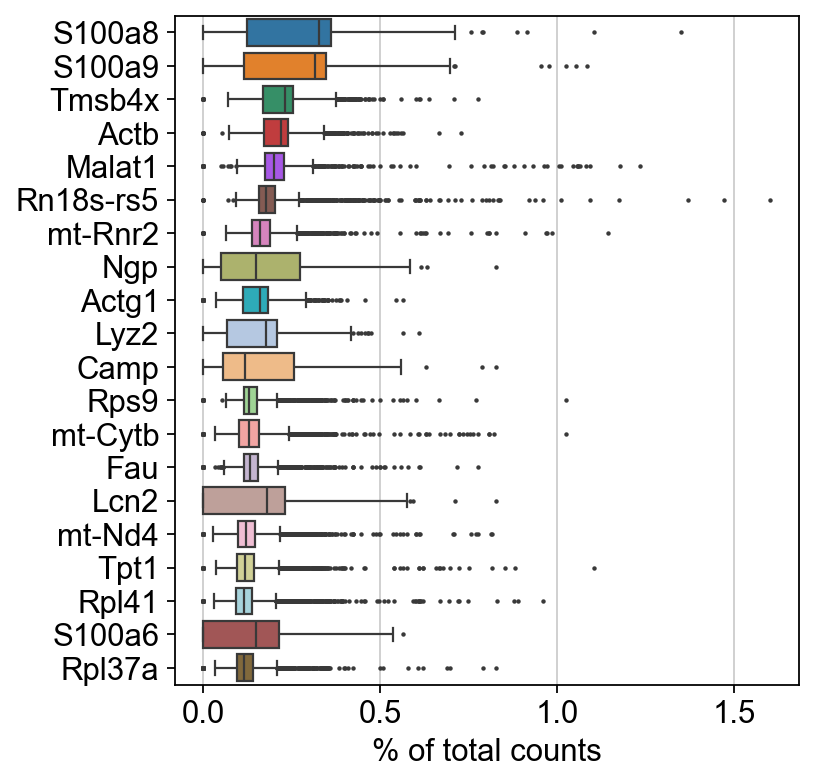

<Figure size 320x320 with 0 Axes>

In [608]:
plotPostNormalization(adata, True)

#### Principal component analysis:

In [609]:
def plotPCA(adata, n_pcs):
    #Calculate PCA:
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pl.pca_variance_ratio(adata, log=True, n_pcs = n_pcs)

    #title is not working...
    fig = plt.gcf()
    plt.suptitle(f"PCA Variance Ratio (Top {n_pcs} PCs in sample: {sample_name})", fontsize=16)
    fig.subplots_adjust(top=0.9)
    plt.show()

computing PCA
    with n_comps=50
    finished (0:00:03)


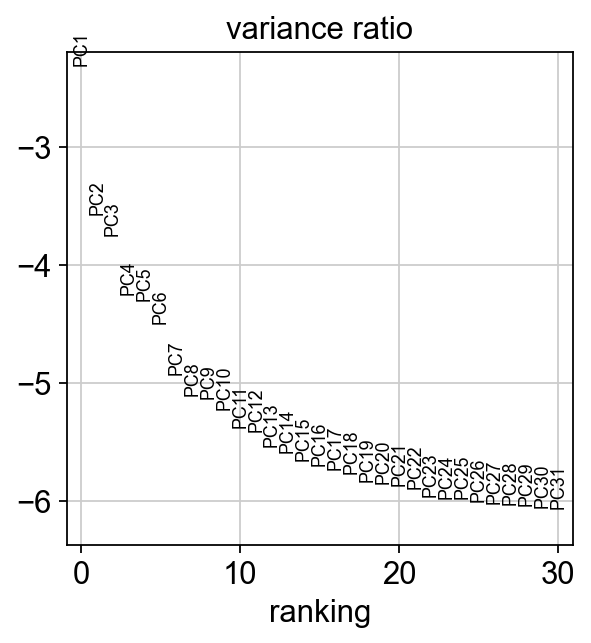

<Figure size 320x320 with 0 Axes>

In [610]:
plotPCA(adata,30)

#### Compute, cluster, and embed the neighborhood graph

In [542]:
def ClusterAnalysis(adata):
    #compute neighbor graph
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    
    #Embed graph into 2 dimensions using UMAP:
    sc.tl.umap(adata)
    
    #perfom leiden clustering:
    sc.tl.leiden(adata)
    
    #compute ranking for highly expressed genes:
    sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")

    #annotate with scoreCT:
    ct.scorect(adata,
          marker_path=marker_file,
          K_top=300,
          m_bins=5,
          null_model='multinomial',
          cluster_key='leiden')

In [611]:
ClusterAnalysis(adata)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:07)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:53)
Reading markers...
Wrangling: Number of markers used in ranked_gene_groups:  56748
Wrangling: Groups used for ranking: leide

#### Plot: Leiden clusters
- function should also plot the names of all 20 most expressed genes

In [612]:
def PlotUMAP(adata, color):
    
    sc.pl.umap(adata, color=[color], title=[f"UMAP of: {sample_name}"], use_raw=False,wspace=0.33)

Index(['Gm37671', 'Gm19087', 'Gm8941', 'Gm38212', 'Gm7449', 'Gm15178',
       'Gm28283', 'Gm37108', 'Gm37275', 'Gm6679', 'Gm29155', 'C730036E19Rik',
       'Gm37225', 'Gm17847', 'Gm28281', 'Gm29157', 'Gm37489', 'Gm29156',
       'Gm22159', 'Gm5694'],
      dtype='object')


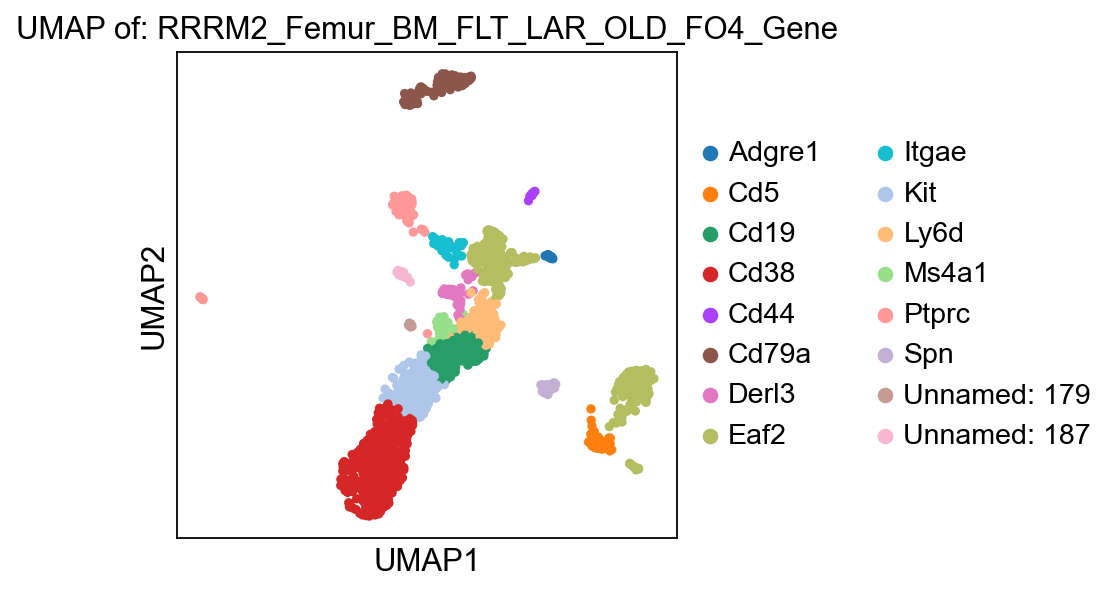

In [569]:
#setting up the color it's possible to visualize UMAP with specific gene
PlotUMAP(adata, color="scoreCT")

In [570]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,Retnlg,Mmp8,Csf3r,Ltf,H2az1,Cd74,Chil3,Clec4a1,Il2rb,Ebf1,...,Psap,Ikzf2,mt-Nd4,Igkc,Cavin2,Siglech,Hbb-bs,Ptma,Cd200r3,Kitl
1,S100a6,Mmp9,Ccl6,Anxa1,Rpsa,Ms4a1,Camp,Clec4a3,Ms4a4b,Atp1b1,...,Ccr2,H2-K1,Rn18s-rs5,Jchain,Pf4,Bst2,Hba-a2,Hmgb1,Csrp3,Cxcl12
2,S100a11,S100a9,Dusp1,Ngp,Ptma,Cd79a,Ngp,Pou2f2,AW112010,Arl5c,...,F13a1,H2-Q7,Igha,Ighm,Myl6,Irf8,Hba-a1,H2az2,Cyp11a1,Gas6
3,Mmp8,Pglyrp1,Cxcr2,AA467197,Rpl28,Cd79b,Orm1,Atp1a1,Gimap3,Vpreb3,...,Lyz2,AW112010,mt-Nd1,Ly6a,Plek,Tcf4,Hbb-bt,Pclaf,Ms4a2,Igfbp5
4,Mmp9,Lcn2,Msrb1,Lcn2,Rpl32,H2-Ab1,Lta4h,Ctss,Gimap4,Bach2,...,Mpeg1,Shisa5,Igkc,Cd74,Tuba4a,Psap,Epb41,Ezh2,Fcer1a,Plpp3


In [571]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        f"{group}_{key[:1]}": result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,16_n,16_p,17_n,17_p,18_n,18_p,19_n,19_p,20_n,20_p
0,Retnlg,1.653494e-100,Mmp8,3.536714e-70,Csf3r,8.320429e-105,Ltf,1.667571e-89,H2az1,1.271348e-60,...,Siglech,2.348176e-09,Hbb-bs,1.038979e-08,Ptma,1.277297e-08,Cd200r3,4.775690e-08,Kitl,0.000023
1,S100a6,2.835538e-86,Mmp9,7.037487e-65,Ccl6,3.044705e-92,Anxa1,1.510102e-78,Rpsa,5.271260e-47,...,Bst2,2.434754e-09,Hba-a2,1.038979e-08,Hmgb1,1.588226e-08,Csrp3,4.775690e-08,Cxcl12,0.000023
2,S100a11,5.907110e-80,S100a9,2.606495e-58,Dusp1,9.003113e-92,Ngp,7.500827e-75,Ptma,9.954467e-47,...,Irf8,3.319514e-09,Hba-a1,1.042761e-08,H2az2,2.298359e-08,Cyp11a1,4.775690e-08,Gas6,0.000023
3,Mmp8,7.653022e-75,Pglyrp1,2.299024e-56,Cxcr2,1.663249e-91,AA467197,1.095293e-74,Rpl28,7.374493e-43,...,Tcf4,5.995547e-09,Hbb-bt,1.046556e-08,Pclaf,2.556343e-08,Ms4a2,4.793119e-08,Igfbp5,0.000023
4,Mmp9,1.305822e-72,Lcn2,1.538318e-51,Msrb1,1.614983e-86,Lcn2,2.702711e-73,Rpl32,3.975284e-41,...,Psap,3.283715e-08,Epb41,1.673025e-08,Ezh2,4.166744e-08,Fcer1a,4.810610e-08,Plpp3,0.000023


In [574]:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


In [576]:
sc.pl.dotplot(adata, marker_file, groupby="leiden");

KeyError: "Could not find keys '['GL-DPPD-7111_Mmus_BoneMarrow_CellType_GeneMarkers_filtered.csv']' in columns of `adata.obs` or in adata.raw.var_names."

### plot chunks:

In [186]:
def sc_process(input_path, organism_filtering, mt_analysis, plots):
    
    # Read the 10x data
    adata = sc.read_10x_mtx(input_path, var_names='gene_symbols', cache=True)
    
    # Retrieve sample name:
    sample_name = os.path.basename(os.path.dirname(input_path))
    adata.obs['sample_name'] = sample_name

    # Basic filtering - percentile based on organism:
    if "mouse" in organism_filtering:
        stat = sc.pp.calculate_qc_metrics(adata)
        cdf = stat[0]
        gdf = stat[1]

        genes = list(set(cdf['n_genes_by_counts'])) # already sorted, why?
        cells = list(set(gdf['n_cells_by_counts']))
    
        print('Filter out cells expressing fewer than: ' + str(np.percentile(genes, 5)) + ' genes')
        print('Filter out genes detected in fewer than: ' + str(np.percentile(cells, 1)) + ' cells')

        #plot distribution of filtered out Genes and Cells:
        if plots:
            plotCellsAndGenes(adata, minGenes=np.percentile(genes, 5), minCells=np.percentile(cells, 1))
    
    #MT_analysis step (optional):
    if mt_analysis:
        mitochondrial_prefixes = ["MT-", "mt-", "M-", "m-", "mito-", "MITO-"]

        # Find which prefix is used in your data
        for prefix in mitochondrial_prefixes:
            mt_genes = [gene for gene in adata.var_names if gene.startswith(prefix)]
            if mt_genes:
                print(f'Prefix "{prefix}" found with {len(mt_genes)} mitochondrial genes:')
                print(mt_genes[:10])  # Print the first 10 mitochondrial genes found
                break
        else:
            print("No common mitochondrial gene prefix found in the first 50 gene names.")

        # Annotate the group of mitochondrial genes as "mt"
        adata.var["mt"] = adata.var_names.str.startswith("mt-")

        # Calculate QC metrics
        sc.pp.calculate_qc_metrics(
            adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

        # Filter out mitochondrial genes:
        adata = adata[adata.obs.n_genes_by_counts < 2500, :] #why 2500? 
        adata = adata[adata.obs.pct_counts_mt < 5, :].copy() #why 5?


    #annotate metrics:
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

    # Violin plot:
    if plots:
        if "pct_counts_mt" in adata.obs:
            sc.pl.violin(
                adata,
                ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
                jitter=0.4,
                multi_panel=True,)
            sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", title="Number of genes vs total counts")
            sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", title="Percent of mitochondrial counts")
        else:
            sc.pl.violin(
                adata,
                ["n_genes_by_counts", "total_counts"],
                jitter=0.4,
                multi_panel=True,)
            sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", title="Number of genes vs total counts")
    
    #filter out too many genes:
    adata = adata[adata.obs.n_genes_by_counts < 2500, :]
    
    # Normalization by library size:
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Save for DE analysis - raw:
    adata.raw = adata.copy()
    
    #identify high variable genes:
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

    #plot 20 highly expressed genes:
    if plots:
        sc.pl.highest_expr_genes(adata, n_top=20)

    # Filter highly variable genes:
    adata = adata[:, adata.var.highly_variable]
    
    # Regress out the variables conditionally
    if "pct_counts_mt" in adata.obs:
        sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
    else:
        sc.pp.regress_out(adata, ["total_counts"])

    # Scale the data:
    sc.pp.scale(adata, max_value=10)

    # Calculate PCA:
    sc.tl.pca(adata, svd_solver="arpack")

    #plot PCA:
    if plots:
        sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50) # PCs should be set dynamically

    # Compute clusters:
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40) #should be set dynamically:
    sc.tl.umap(adata)

    # Cluster Leiden:
    sc.tl.leiden(adata, resolution=0.9) #set up resolution as parameter!

    # Differential expression analysis between clusters:
    sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")

    # Use scoreCT:
    ct.scorect(adata,
               marker_path=input_marker_path,
               K_top=300,
               m_bins=5,
               null_model='multinomial',
               cluster_key='leiden')
    
    #plot UMAP:
    if plots:
        sc.pl.umap(adata, color=['scoreCT'], title=["UMAP of file:"], wspace=0.33)
    return adata

### Executing functions:

In [ ]:
scRNAseq_output = []
for input_path in out:
    adata = sc_process(input_path, "mouse", mt_analysis=False, plots= False)
    scRNAseq_output.append(adata)

In [182]:
adata_concatenated = sc.concat(scRNAseq_output)

In [185]:
adata_concatenated.obs

,sample_name,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,scoreCT
AAACGAAAGATTAGCA,RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene,1958,4134.0,0.0,0.0,2,Eaf2
AAACGAACAACGACAG,RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene,1298,3963.0,0.0,0.0,4,Cd38
AAACGAATCAAGTGGG,RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene,1827,3658.0,0.0,0.0,12,Sec11c
AAACGCTTCAACCTCC,RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene,2392,10139.0,0.0,0.0,0,Cd19
AAAGAACTCAGCCTCT,RRRM2_Femur_BM_FLT_LAR_OLD_FO4_Gene,2005,3881.0,0.0,0.0,7,Cd79a
...,...,...,...,...,...,...,...
TTTGGTTCATGGCTAT,RRRM2_Femur_BM_FLT_LAR_YNG_FY11_Gene,1632,4087.0,0.0,0.0,2,Cd24a
TTTGTTGCAGACGCTC,RRRM2_Femur_BM_FLT_LAR_YNG_FY11_Gene,1106,8962.0,0.0,0.0,17,Adgre1
TTTGTTGCATGTACGT,RRRM2_Femur_BM_FLT_LAR_YNG_FY11_Gene,414,532.0,0.0,0.0,0,Kit
TTTGTTGTCACCTGGG,RRRM2_Femur_BM_FLT_LAR_YNG_FY11_Gene,1822,6921.0,0.0,0.0,0,Kit
